In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from an .env file
load_dotenv()

True

In [2]:
import pandas as pd
from sqlalchemy import create_engine

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data_from_db(connection_string, query):
    engine = create_engine(connection_string)
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df

In [4]:
# Access the environment variables
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [5]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}'

In [6]:
df = load_data_from_db(connection_string, """select * from feature_set limit 250000""")

# Select cards with non-zero prices

In [7]:
df = df.loc[(df.product_type == "card") & (df.price != 0)]
df.shape

(165318, 36)

# In fact, cards with non-trivial prices only (at least $10-20)

In [8]:
df = df.loc[df.price>=20]

In [9]:
df.card_type.value_counts()

card_type
NaN                          88190
full art                      1020
full art secret                698
illustration rare              188
special illustration rare       92
shiny ultra rare                31
ultra rare                      24
hyper rare                      18
Name: count, dtype: int64

# Get average, monthly price of grade for each grade

In [13]:
avg_by_grade = df.groupby(['date', 'grade']).agg(avg_by_grade=('price','mean'))
df = pd.merge(df, avg_by_grade, how="left", on=['date', 'grade'])

# Combine binary features to composite features using heuristic simple logic
- iterate and optimize on these

In [16]:
#df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
#df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Assign integer grades to all cards

In [17]:
grade_mapping = {
    'nearmint': 8,
    'psa_10': 10,
    'psa_9': 9,
    'bgs_9_half': 9.5,
    'psa_8': 8,
    'psa_7': 7
}

# Create the new column `num_grade` using the mapping
df['num_grade'] = df['grade'].map(grade_mapping)

# Categorize Grade

In [18]:
# Function to categorize grade
def categorize_grade(grade):
    if grade == 10:
        return 1  # Highest value (Grade 10)
    elif grade >= 8:
        return 2  # Middle value (Grade 8-9)
    else:
        return 3  # Lower value (below Grade 8)

# Apply categorization to 'num_grade' column
df['grade_category'] = df['num_grade'].apply(categorize_grade)

In [19]:
df["grade_category"].value_counts()

grade_category
2    52494
1    33966
3     3801
Name: count, dtype: int64

# Create column is_nearmint

In [20]:
df['is_near_mint_ungraded'] = (df['grade'] == 'nearmint').astype(int)

In [21]:
df.is_near_mint_ungraded.value_counts()

is_near_mint_ungraded
0    81668
1     8593
Name: count, dtype: int64

# Create time buckets

In [22]:
def categorize_months(months):
    if months>=12 and months <=24:
        return 'between_1_2_year'
    elif months>24:
        return 'over_2_year'

# Apply the categorization
df['time_bucket'] = df['mos_since_release'].apply(categorize_months).astype(str)
df.time_bucket.head(3)

0                None
1                None
2    between_1_2_year
Name: time_bucket, dtype: object

In [23]:
df.time_bucket.value_counts()

time_bucket
over_2_year         57690
None                16574
between_1_2_year    15997
Name: count, dtype: int64

# OHE

In [24]:
df = pd.get_dummies(df, columns=['time_bucket'], drop_first=False)
df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
df.head(3)

C:\Users\huang\AppData\Local\Temp\ipykernel_1336\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_1336\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_1336\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

,date,price,grade,poke_name,poke_no,set_name,product_type,set_year,set_month,execution_datetime,...,avg_mo_price_psa_10_in_set,max_mo_price_psa_10_in_set,avg_by_grade,ir_score,num_grade,grade_category,is_near_mint_ungraded,time_bucket_None,time_bucket_between_1_2_year,time_bucket_over_2_year
0,2021-09-01,61.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,...,105.05,667.50,55.777290,0,8.0,2,0,1,0,0
1,2021-10-01,61.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,...,96.76,632.95,54.072606,0,8.0,2,0,1,0,0
2,2021-11-01,49.0,psa_8,pikachu-vmax,44,vivid-voltage,card,2020,11,2024-11-07 00:50:40.190157,...,87.41,597.50,51.436629,0,8.0,2,0,0,1,0


# Select features

In [25]:
df.columns

Index(['date', 'price', 'grade', 'poke_name', 'poke_no', 'set_name',
       'product_type', 'set_year', 'set_month', 'execution_datetime',
       'poke_id', 'card_type', 'release_date', 'mos_since_release',
       'is_secret', 'is_full_art', 'is_full_art_secret', 'is_ir', 'is_sir',
       'is_ultra_rare', 'is_shiny_rare', 'is_eeveelution', 'is_legendary',
       'is_og_char', 'is_gallery', 'avg_mo_price_sealed_in_set',
       'max_mo_price_sealed_in_set', 'avg_mo_price_card_in_set',
       'max_mo_price_card_in_set', 'top10_nm_card_mo_sum_in_set',
       'top10_nm_card_mo_avg_in_set', 'bb_mo_price_by_set',
       'etb_mo_price_by_set', 'top10_mo_card_sum_to_bb_cost_ratio',
       'avg_mo_price_psa_10_in_set', 'max_mo_price_psa_10_in_set',
       'avg_by_grade', 'ir_score', 'num_grade', 'grade_category',
       'is_near_mint_ungraded', 'time_bucket_None',
       'time_bucket_between_1_2_year', 'time_bucket_over_2_year'],
      dtype='object')

In [66]:
features = ["mos_since_release", "avg_by_grade",
            'is_near_mint_ungraded', 
            #'grade_category', 
            'num_grade',
            'is_secret', 'is_full_art', 'is_eeveelution', 'is_legendary',
       'is_og_char', 'is_gallery',
            'bb_mo_price_by_set', 
            'ir_score'
           ]

df[["poke_id"]+["poke_name"]+features+["price"]].head(3)

,poke_id,poke_name,mos_since_release,avg_by_grade,is_near_mint_ungraded,num_grade,is_secret,is_full_art,is_eeveelution,is_legendary,is_og_char,is_gallery,bb_mo_price_by_set,ir_score,price
0,44vivid-voltage,pikachu-vmax,10,55.777290,0,8.0,False,False,False,False,True,False,148.82,0,61.0
1,44vivid-voltage,pikachu-vmax,11,54.072606,0,8.0,False,False,False,False,True,False,159.75,0,61.0
2,44vivid-voltage,pikachu-vmax,12,51.436629,0,8.0,False,False,False,False,True,False,127.59,0,49.0


# Corr matrix

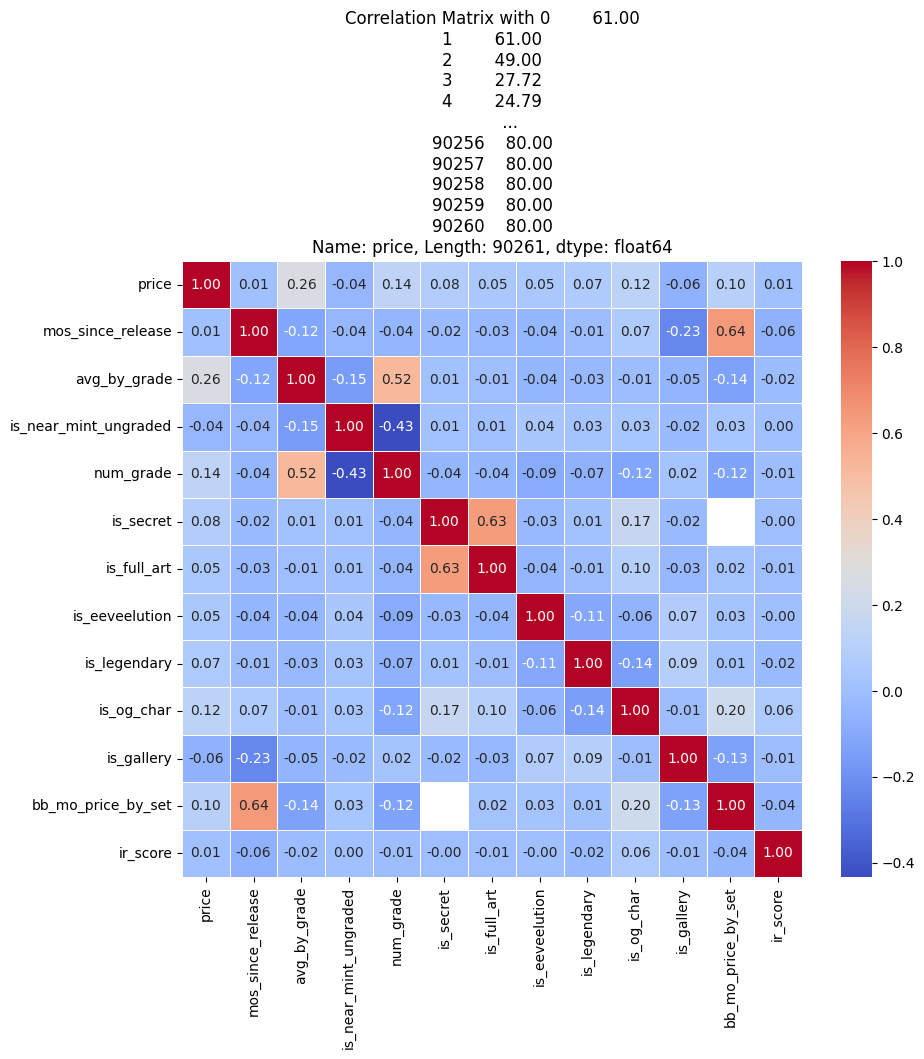

In [67]:
def plot_correlation_matrix(df, target_col):
    # Compute the correlation matrix
    corr = df.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix with {target_col}')
    plt.show()
    
plot_correlation_matrix(df[["price"]+features], df["price"])

# Train model

In [68]:
def train_xgboost_model(X, y):
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

In [69]:
xgb_model = train_xgboost_model(df[features], df["price"])

XGBoost model RMSE: 99.6243


C:\Users\huang\OneDrive\Desktop\projects\poke_ai\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


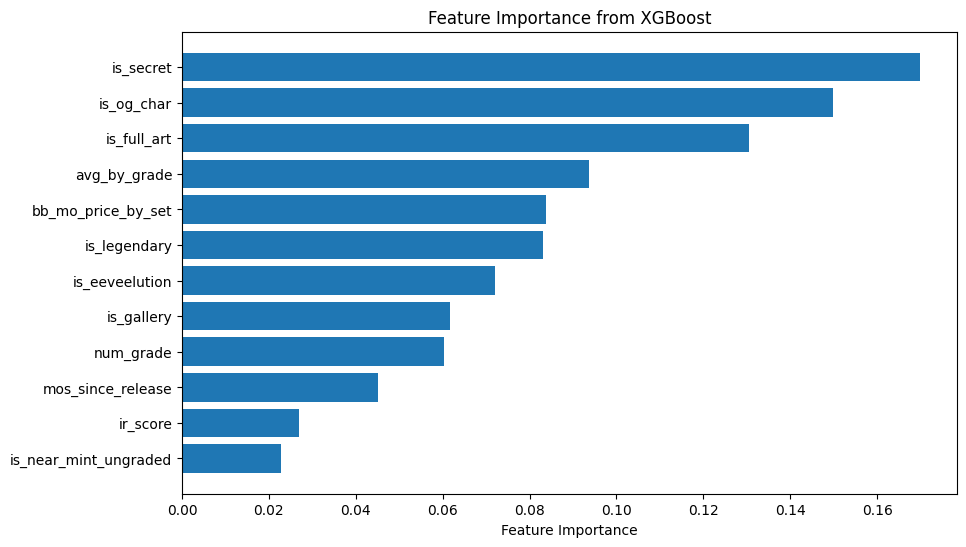

In [70]:
def plot_feature_importance(model, X):
    # Get feature importance from the model
    feature_importances = model.feature_importances_

    # Sort features by importance
    sorted_idx = feature_importances.argsort()

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from XGBoost")
    plt.show()

plot_feature_importance(xgb_model, df[features])

# Look at price distribution, clipped
- Around $60-80 avg

In [71]:
clipped = df.loc[df.price<=500]

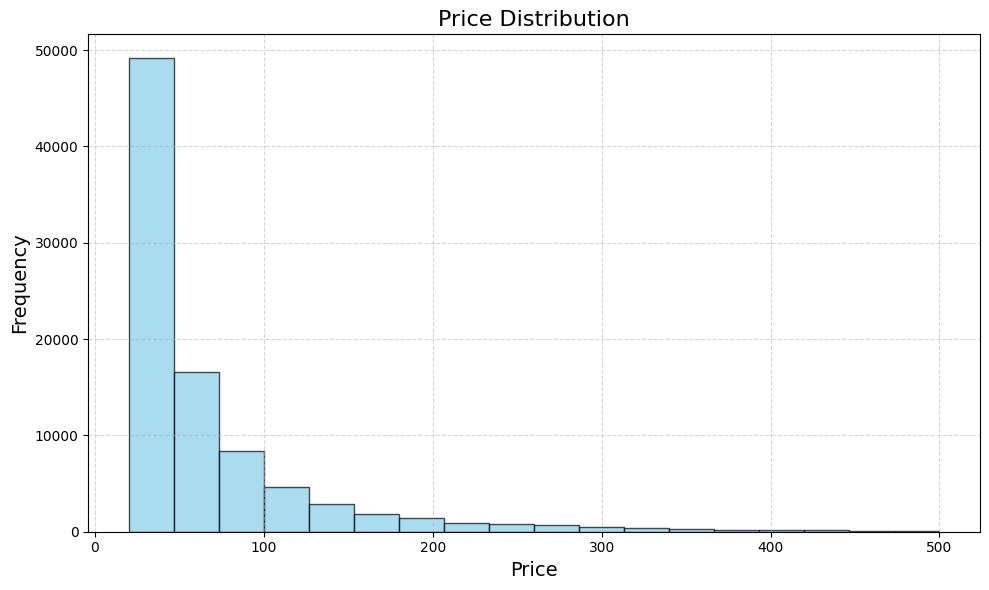

In [72]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=18, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adding gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()  # Adjusts plot to ensure everything fits
plt.show()

# Try GridSearching briefly to optimize hyperparameters

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(df[features], df["price"])
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [74]:
# Best parameters and corresponding RMSE (calculated from negative MSE)
print("Best parameters:", grid_search.best_params_)
best_score = np.sqrt(-grid_search.best_score_)  # Convert from negative MSE to RMSE
print("Best RMSE score:", best_score)

# Detailed grid search results
results = grid_search.cv_results_

# Optional: Show the top 5 best parameter combinations based on the best RMSE
results_df = pd.DataFrame(results)
results_df = results_df[['mean_test_score', 'std_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_score'])  # Convert MSE to RMSE
results_df['std_test_rmse'] = np.sqrt(results_df['std_test_score'])  # Convert std MSE to RMSE
results_df.sort_values(by="mean_test_rmse", ascending=True).head(5)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best RMSE score: 106.83826262025961


,mean_test_score,std_test_score,param_learning_rate,param_max_depth,param_n_estimators,mean_test_rmse,std_test_rmse
2,-11414.414360,3848.860593,0.01,3,200,106.838263,62.039186
1,-11444.630464,3946.698177,0.01,3,100,106.979580,62.822752
6,-11487.113079,4147.052649,0.01,7,50,107.177951,64.397614
9,-11496.722145,3817.912096,0.10,3,50,107.222769,61.789256
7,-11512.573967,4025.819441,0.01,7,100,107.296663,63.449345


# Check under/overfit with best model

In [75]:
def train_xgboost_model(X, y):
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

learning_rate=0.01, max_depth=5 to 7, n_estimators=150

In [97]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df["price"], test_size=0.2, random_state=42)


# Initialize XGBoost model with specified hyperparameters
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         eval_metric='rmse',
                         learning_rate=0.01, 
                         max_depth=5, 
                         n_estimators=100)

# Fit the model to the training data
model.fit(df[features], df["price"])

# Make predictions on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"diff: {round(abs(train_rmse-val_rmse),2)}")

mean_price = df.price.mean()
std_dev = np.sqrt(df['price'].var())
print("\nMean Price is", mean_price, "with std_dev", std_dev)
print("Est. model predictions on average, will be off by more than", round(((train_rmse/mean_price)*1),2), f"x")

Training RMSE: 100.6388
Validation RMSE: 101.7912
diff: 1.15

Mean Price is 74.7995778907834 with std_dev 109.53388087112378
Est. model predictions on average, will be off by more than 1.35 x


# Test prediction

In [98]:
import numpy as np

def predict_card_price(model, test_features, feature_columns):
    test_features = pd.DataFrame([test_features], columns=feature_columns)
    
    predicted_price = model.predict(test_features)[0]
    
    return predicted_price

# Save TF Model

from datetime import datetime


current_datetime = datetime.now()
formatted_date = current_datetime.strftime('%m-%d-%Y')
model.save_model(f'my_model_{formatted_date}.bin')

- df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
- df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
- df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Formatted test payload

In [104]:
test_features = {
    "avg_by_grade": 100,
    "mos_since_release": 12,
    'is_near_mint_ungraded': 0,
    'num_grade': 10,
   # 'grade_category': 1, # 1= psa 10, 2= 8 or 9, 3 = else
    'rarity_score': 3,
    'popularity_score':1,
    'ir_score': 0,
    'bb_mo_price_by_set': 100
}

# Get the predicted price for the card
predicted_price = predict_card_price(model, test_features, features)

print(f"Predicted price for the card: ${predicted_price:.2f}")

Predicted price for the card: $138.29


# How to enforce non-zero / non-negative / unrealistic price predictions? 
- give model more examples...
- handle with railguards post inference (step functions or rules to process model predictions and handle well)

## 